<a href="https://colab.research.google.com/github/ShangWeiKuo/Portfolio/blob/main/Python/Classification/Binary/Parkinson's%20Disease/Parkinson_CNN_VGG_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [3]:
train_path = '/content/drive/MyDrive/drawings/training'
test_path = '/content/drive/MyDrive/drawings/testing'
BATCH_SIZE = 32

In [4]:
train= tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                            shear_range=0.2, 
                            zoom_range=0.2, 
                            horizontal_flip=True)
test= tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
training_set = train.flow_from_directory(train_path, 
                      target_size=(255, 255), 
                      class_mode = 'binary', 
                      classes=['healthy', 'parkinson'], 
                      shuffle=True, 
                      batch_size=32)
val_set = test.flow_from_directory(test_path, 
                   target_size=(255, 255), 
                   class_mode = 'binary', 
                   classes=['healthy', 'parkinson'], 
                   shuffle=True, 
                   batch_size=32)

Found 144 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


(255, 255, 3)


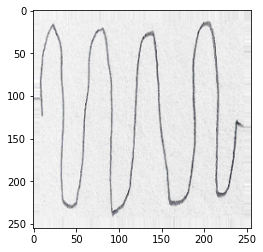

(255, 255, 3)


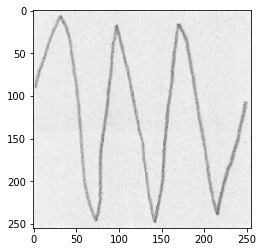

(255, 255, 3)


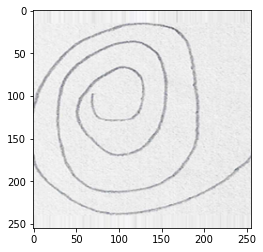

In [5]:
for i in range(0, 3):
  img, label = training_set.next()
  print(img[i].shape)
  plt.imshow(img[i])
  plt.show()

In [6]:
def recall_m(y_true, y_pred):
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # True-Positive
  PP = K.sum(K.round(K.clip(y_true, 0, 1))) # Possible positives
  recall = TP / (PP + K.epsilon())
  return recall

In [7]:
def precision_m(y_true, y_pred):
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # True-Positive
  PP = K.sum(K.round(K.clip(y_pred, 0, 1))) # Predicted positives
  precision = TP / (PP + K.epsilon())
  return precision

In [8]:
def f1_m(y_true, y_pred):
  recall = recall_m(y_true, y_pred)
  precision = precision_m(y_true, y_pred)
  return 2*((precision*recall) / (precision+recall+K.epsilon()))

In [9]:
vgg16_model = keras.applications.vgg16.VGG16()

In [10]:
model = Sequential()

In [11]:
for layer in vgg16_model.layers[:-4]:
  model.add(layer)

for layer in model.layers:
  layer.trainable = False

In [12]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [14]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=1e-6), loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
History = model.fit_generator(training_set, steps_per_epoch=training_set.n//BATCH_SIZE, validation_data=val_set, validation_steps=val_set.n//BATCH_SIZE, epochs=50, verbose=2, callbacks=[es])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
4/4 - 84s - loss: 1.6476 - accuracy: 0.6429 - f1_m: 0.4940 - precision_m: 0.5811 - recall_m: 0.5095 - val_loss: 4.6191 - val_accuracy: 0.5000 - val_f1_m: 0.6667 - val_precision_m: 0.5000 - val_recall_m: 1.0000
Epoch 2/50
4/4 - 81s - loss: 3.0257 - accuracy: 0.5982 - f1_m: 0.5372 - precision_m: 0.4260 - recall_m: 0.7321 - val_loss: 2.6847 - val_accuracy: 0.5625 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/50
4/4 - 90s - loss: 1.7334 - accuracy: 0.6562 - f1_m: 0.5266 - precision_m: 0.8712 - recall_m: 0.4806 - val_loss: 2.2030 - val_accuracy: 0.4688 - val_f1_m: 0.6383 - val_precision_m: 0.4688 - val_recall_m: 1.0000
Epoch 4/50
4/4 - 81s - loss: 1.3354 - accuracy: 0.6429 - f1_m: 0.7146 - precision_m: 0.6073 - recall_m: 0.9000 - val_loss: 0.6782 - val_accuracy: 0.8438 - val_f1_m: 0.8148 - val_precision_m: 0.9167 - val_recall_m: 0.7333
Epoch 5/50
4/4 - 82s - loss: 1.2359 - accuracy: 0.6964 - f1_m: 0.6087 - precision_m: 0.8813 - recall_m: 

In [17]:
# Evaluation 1 - Training data
scores_train = model.evaluate(training_set, steps=training_set.n//BATCH_SIZE)
print("Accuracy: ", round(scores_train[1], 3))
print("F1-Score: ", round(scores_train[2], 3))
print("Precision: ", round(scores_train[3], 3))
print("Recall: ", round(scores_train[4], 3))

4/4 [==============================] - 72s 18s/step - loss: 0.1075 - accuracy: 0.9688 - f1_m: 0.9695 - precision_m: 0.9529 - recall_m: 0.9875
Accuracy:  0.969
F1-Score:  0.969
Precision:  0.953
Recall:  0.988


In [18]:
# Evaluation 2 - Testing data
scores_test = model.evaluate(val_set, steps=val_set.n//BATCH_SIZE)
print("Accuracy: ", round(scores_test[1], 3))
print("F1-Score: ", round(scores_test[2], 3))
print("Precision: ", round(scores_test[3], 3))
print("Recall: ", round(scores_test[4], 3))

1/1 [==============================] - 18s 18s/step - loss: 0.4390 - accuracy: 0.8750 - f1_m: 0.8571 - precision_m: 0.8571 - recall_m: 0.8571
Accuracy:  0.875
F1-Score:  0.857
Precision:  0.857
Recall:  0.857


In [19]:
# Evaluation - Overview
eval_df = np.array(
            [
              [round(scores_train[1], 3), round(scores_test[1], 3)], 
              [round(scores_train[2], 3), round(scores_test[2], 3)],
              [round(scores_train[3], 3), round(scores_test[3], 3)],
              [round(scores_train[4], 3), round(scores_test[4], 3)]
            ]
          )

eval_df = pd.DataFrame(eval_df, columns=['Train', 'Test'])
rowname = np.array(['Accuracy', 'F1-Score', 'Precision', 'Recall'])
eval_df.index = rowname
eval_df

,Train,Test
Accuracy,0.969,0.875
F1-Score,0.969,0.857
Precision,0.953,0.857
Recall,0.988,0.857


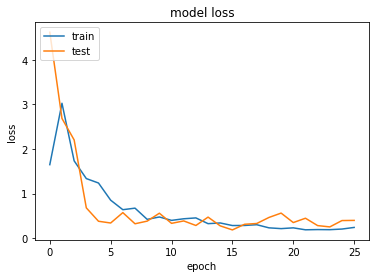

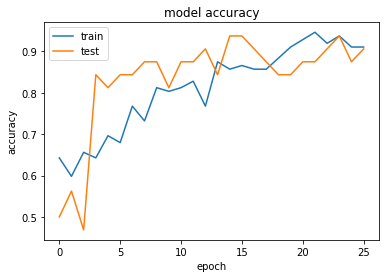

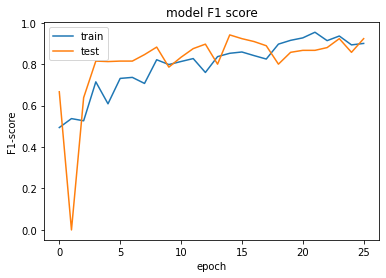

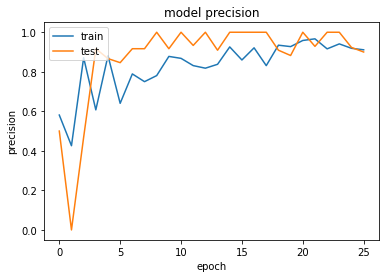

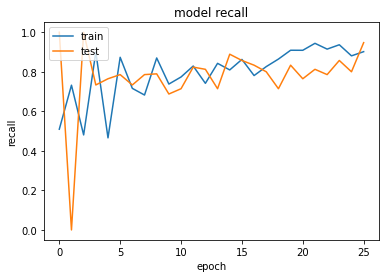

In [20]:
# Loss plot
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Accuracy plot 
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# F1-score plot
plt.plot(History.history['f1_m'])
plt.plot(History.history['val_f1_m'])
plt.title('model F1 score')
plt.ylabel('F1-score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Precision plot
plt.plot(History.history['precision_m'])
plt.plot(History.history['val_precision_m'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Recall plot
plt.plot(History.history['recall_m'])
plt.plot(History.history['val_recall_m'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()